In [1]:
!pip install torch torchvision tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.5 MB/s eta 0:00:00


In [2]:
import torch, torchvision
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch: 2.6.0+cu124
CUDA available: True


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import time

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

trainset = torchvision.datasets.CIFAR10(root='./cifar_data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./cifar_data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


# Load VGG-16 as Teacher

In [6]:
teacher_model = torchvision.models.vgg16(pretrained=True)
teacher_model.classifier[6] = nn.Linear(4096, 10)
teacher_model = teacher_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.4MB/s]


# Define Student Model (3-layer CNN)

In [7]:
class StudentCNN(nn.Module):
    def __init__(self):
        super(StudentCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

student_model = StudentCNN().to(device)
student_model_hard = StudentCNN().to(device)

# Define Distillation Loss

In [8]:
def distillation_loss(y_pred, y_teacher, y_true, temperature=2.0, alpha=0.7):
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(y_pred / temperature, dim=1),
                                                    F.softmax(y_teacher / temperature, dim=1)) * (temperature ** 2)
    hard_loss = nn.CrossEntropyLoss()(y_pred, y_true)
    return alpha * soft_loss + (1 - alpha) * hard_loss

# Callbacks

In [9]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = np.inf

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        torch.save(model.state_dict(), path)
        self.best_loss = val_loss

# Evaluate Accuracy

In [10]:
def evaluate_model(model, testloader, criterion, teacher=None):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if teacher:
                teacher_outputs = teacher(inputs)
                loss = criterion(outputs, teacher_outputs, labels)
            else:
                loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return total_loss / len(testloader), 100 * correct / total

# training function

In [11]:
def train_model(model, trainloader, criterion, optimizer, epochs, early_stopping=None, teacher=None, distillation=False, scheduler=None):
    model.train()
    start_time = time.time()
    for epoch in tqdm(range(epochs), desc="Epochs", total=epochs):
        running_loss = 0.0
        epoch_start_time = time.time()
        for inputs, labels in trainloader:  # No inner tqdm to avoid console clutter
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            if distillation and teacher:
                with torch.no_grad():
                    teacher_outputs = teacher(inputs)
                loss = criterion(outputs, teacher_outputs, labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        epoch_time = time.time() - epoch_start_time
        epochs_remaining = epochs - (epoch + 1)

        # Validation
        val_loss, val_acc = evaluate_model(model, testloader, criterion, teacher if distillation else None)

        # Print epoch-level information to console
        print(f'\nEpoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s')
        print(f'Epochs Remaining: {epochs_remaining}, Estimated Time Remaining: {epoch_time * epochs_remaining:.2f}s')
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

        if early_stopping:
            early_stopping(val_loss, model, f'checkpoint_{model.__class__.__name__}.pt')
            if early_stopping.early_stop:
                print("Early stopping triggered")
                break

        if scheduler:
            scheduler.step()

# Train Teacher Model

In [12]:
print("\nTraining Teacher Model (VGG-16)...")
teacher_optimizer = optim.SGD([
    {'params': teacher_model.features.parameters(), 'lr': 1e-3},
    {'params': teacher_model.classifier.parameters(), 'lr': 1e-2}
], momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(teacher_optimizer, step_size=5, gamma=0.1)
teacher_criterion = nn.CrossEntropyLoss()
early_stopping_teacher = EarlyStopping(patience=3)
train_model(teacher_model, trainloader, teacher_criterion, teacher_optimizer, epochs=20,
            early_stopping=early_stopping_teacher, scheduler=scheduler)

print("\nEvaluating Teacher Model...")
teacher_loss, teacher_acc = evaluate_model(teacher_model, testloader, teacher_criterion)
print(f'Teacher Test Loss: {teacher_loss:.4f}, Accuracy: {teacher_acc:.4f}%')


Training Teacher Model (VGG-16)...


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20, Loss: 0.9545, Time: 52.10s
Epochs Remaining: 19, Estimated Time Remaining: 989.87s
Validation Loss: 0.6208, Accuracy: 78.9100


Epochs:   5%|▌         | 1/20 [00:58<18:26, 58.21s/it]


Epoch 2/20, Loss: 0.6132, Time: 52.21s
Epochs Remaining: 18, Estimated Time Remaining: 939.84s
Validation Loss: 0.4944, Accuracy: 83.1600


Epochs:  10%|█         | 2/20 [01:57<17:39, 58.87s/it]


Epoch 3/20, Loss: 0.5148, Time: 53.35s
Epochs Remaining: 17, Estimated Time Remaining: 906.97s
Validation Loss: 0.4655, Accuracy: 84.0700


Epochs:  15%|█▌        | 3/20 [02:57<16:46, 59.20s/it]


Epoch 4/20, Loss: 0.4632, Time: 53.39s
Epochs Remaining: 16, Estimated Time Remaining: 854.24s
Validation Loss: 0.4121, Accuracy: 85.9800


Epochs:  20%|██        | 4/20 [03:58<16:00, 60.04s/it]


Epoch 5/20, Loss: 0.4195, Time: 53.24s
Epochs Remaining: 15, Estimated Time Remaining: 798.60s
Validation Loss: 0.3831, Accuracy: 86.8100


Epochs:  25%|██▌       | 5/20 [04:57<14:57, 59.82s/it]


Epoch 6/20, Loss: 0.3367, Time: 53.16s
Epochs Remaining: 14, Estimated Time Remaining: 744.21s
Validation Loss: 0.3643, Accuracy: 87.8400


Epochs:  30%|███       | 6/20 [05:57<13:55, 59.65s/it]


Epoch 7/20, Loss: 0.3199, Time: 53.10s
Epochs Remaining: 13, Estimated Time Remaining: 690.28s
Validation Loss: 0.3576, Accuracy: 88.0700


Epochs:  35%|███▌      | 7/20 [06:58<13:02, 60.17s/it]


Epoch 8/20, Loss: 0.3157, Time: 53.26s
Epochs Remaining: 12, Estimated Time Remaining: 639.14s
Validation Loss: 0.3556, Accuracy: 88.1700


Epochs:  40%|████      | 8/20 [07:56<11:55, 59.60s/it]


Epoch 9/20, Loss: 0.3084, Time: 53.34s
Epochs Remaining: 11, Estimated Time Remaining: 586.77s
Validation Loss: 0.3541, Accuracy: 88.3800


Epochs:  50%|█████     | 10/20 [09:55<09:52, 59.22s/it]


Epoch 10/20, Loss: 0.3031, Time: 53.49s
Epochs Remaining: 10, Estimated Time Remaining: 534.90s
Validation Loss: 0.3553, Accuracy: 88.1900

Epoch 11/20, Loss: 0.2965, Time: 52.98s
Epochs Remaining: 9, Estimated Time Remaining: 476.83s
Validation Loss: 0.3526, Accuracy: 88.2700


Epochs:  55%|█████▌    | 11/20 [10:56<08:58, 59.80s/it]


Epoch 12/20, Loss: 0.2947, Time: 53.33s
Epochs Remaining: 8, Estimated Time Remaining: 426.66s
Validation Loss: 0.3519, Accuracy: 88.3200


Epochs:  65%|██████▌   | 13/20 [12:54<06:54, 59.24s/it]


Epoch 13/20, Loss: 0.2880, Time: 53.48s
Epochs Remaining: 7, Estimated Time Remaining: 374.34s
Validation Loss: 0.3527, Accuracy: 88.3000


Epochs:  70%|███████   | 14/20 [13:50<05:50, 58.34s/it]


Epoch 14/20, Loss: 0.2898, Time: 53.01s
Epochs Remaining: 6, Estimated Time Remaining: 318.05s
Validation Loss: 0.3530, Accuracy: 88.3600

Epoch 15/20, Loss: 0.2896, Time: 53.58s
Epochs Remaining: 5, Estimated Time Remaining: 267.88s
Validation Loss: 0.3513, Accuracy: 88.4000


Epochs:  80%|████████  | 16/20 [15:49<03:54, 58.63s/it]


Epoch 16/20, Loss: 0.2899, Time: 53.24s
Epochs Remaining: 4, Estimated Time Remaining: 212.95s
Validation Loss: 0.3515, Accuracy: 88.4400


Epochs:  85%|████████▌ | 17/20 [16:45<02:53, 57.96s/it]


Epoch 17/20, Loss: 0.2890, Time: 53.12s
Epochs Remaining: 3, Estimated Time Remaining: 159.37s
Validation Loss: 0.3516, Accuracy: 88.4500


Epochs:  85%|████████▌ | 17/20 [17:42<03:07, 62.51s/it]


Epoch 18/20, Loss: 0.2890, Time: 53.00s
Epochs Remaining: 2, Estimated Time Remaining: 105.99s
Validation Loss: 0.3517, Accuracy: 88.4800
Early stopping triggered

Evaluating Teacher Model...


Teacher Test Loss: 0.3517, Accuracy: 88.4800%


In [14]:
# Save Teacher Model
torch.save(teacher_model.state_dict(), './models/teacher_vgg16.pt')

# Train Student Model with Distillation


In [15]:
print("\nTraining Student Model with Distillation...")
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)
scheduler = StepLR(student_optimizer, step_size=5, gamma=0.1)
early_stopping_student = EarlyStopping(patience=3)
train_model(student_model, trainloader, distillation_loss, student_optimizer, epochs=20,
            early_stopping=early_stopping_student, teacher=teacher_model, distillation=True, scheduler=scheduler)

print("\nEvaluating Student Model (Distilled)...")
student_loss, student_acc = evaluate_model(student_model, testloader, distillation_loss, teacher=teacher_model)
print(f'Student (Distilled) Test Loss: {student_loss:.4f}, Accuracy: {student_acc:.4f}%')


Training Student Model with Distillation...


Epochs:   5%|▌         | 1/20 [00:32<10:11, 32.21s/it]


Epoch 1/20, Loss: 3.0998, Time: 28.74s
Epochs Remaining: 19, Estimated Time Remaining: 546.09s
Validation Loss: 2.5606, Accuracy: 52.9600


Epochs:  10%|█         | 2/20 [01:03<09:27, 31.54s/it]


Epoch 2/20, Loss: 2.0821, Time: 27.36s
Epochs Remaining: 18, Estimated Time Remaining: 492.43s
Validation Loss: 1.8899, Accuracy: 63.2100


Epochs:  15%|█▌        | 3/20 [01:37<09:17, 32.80s/it]


Epoch 3/20, Loss: 1.7334, Time: 30.56s
Epochs Remaining: 17, Estimated Time Remaining: 519.52s
Validation Loss: 1.5666, Accuracy: 68.2300


Epochs:  20%|██        | 4/20 [02:07<08:26, 31.66s/it]


Epoch 4/20, Loss: 1.5458, Time: 26.53s
Epochs Remaining: 16, Estimated Time Remaining: 424.46s
Validation Loss: 1.5142, Accuracy: 69.0200


Epochs:  25%|██▌       | 5/20 [02:37<07:47, 31.16s/it]


Epoch 5/20, Loss: 1.4189, Time: 26.88s
Epochs Remaining: 15, Estimated Time Remaining: 403.27s
Validation Loss: 1.3425, Accuracy: 71.9700


Epochs:  30%|███       | 6/20 [03:07<07:10, 30.73s/it]


Epoch 6/20, Loss: 1.2222, Time: 25.95s
Epochs Remaining: 14, Estimated Time Remaining: 363.30s
Validation Loss: 1.2211, Accuracy: 73.0000


Epochs:  35%|███▌      | 7/20 [03:37<06:35, 30.40s/it]


Epoch 7/20, Loss: 1.1919, Time: 26.36s
Epochs Remaining: 13, Estimated Time Remaining: 342.66s
Validation Loss: 1.1857, Accuracy: 73.6700


Epochs:  40%|████      | 8/20 [04:07<06:02, 30.19s/it]


Epoch 8/20, Loss: 1.1709, Time: 26.37s
Epochs Remaining: 12, Estimated Time Remaining: 316.46s
Validation Loss: 1.1803, Accuracy: 74.2700


Epochs:  45%|████▌     | 9/20 [04:37<05:32, 30.27s/it]


Epoch 9/20, Loss: 1.1505, Time: 26.27s
Epochs Remaining: 11, Estimated Time Remaining: 289.01s
Validation Loss: 1.1545, Accuracy: 74.4400


Epochs:  50%|█████     | 10/20 [05:08<05:04, 30.46s/it]


Epoch 10/20, Loss: 1.1345, Time: 27.51s
Epochs Remaining: 10, Estimated Time Remaining: 275.13s
Validation Loss: 1.1561, Accuracy: 74.1700


Epochs:  55%|█████▌    | 11/20 [05:38<04:32, 30.25s/it]


Epoch 11/20, Loss: 1.1169, Time: 26.45s
Epochs Remaining: 9, Estimated Time Remaining: 238.07s
Validation Loss: 1.1440, Accuracy: 74.5200


Epochs:  60%|██████    | 12/20 [06:08<04:02, 30.29s/it]


Epoch 12/20, Loss: 1.1139, Time: 26.45s
Epochs Remaining: 8, Estimated Time Remaining: 211.59s
Validation Loss: 1.1361, Accuracy: 74.6700


Epochs:  65%|██████▌   | 13/20 [06:38<03:31, 30.15s/it]


Epoch 13/20, Loss: 1.1119, Time: 26.43s
Epochs Remaining: 7, Estimated Time Remaining: 184.98s
Validation Loss: 1.1365, Accuracy: 74.6500


Epochs:  70%|███████   | 14/20 [07:08<03:00, 30.11s/it]


Epoch 14/20, Loss: 1.1160, Time: 26.48s
Epochs Remaining: 6, Estimated Time Remaining: 158.91s
Validation Loss: 1.1343, Accuracy: 74.7000


Epochs:  75%|███████▌  | 15/20 [07:38<02:31, 30.22s/it]


Epoch 15/20, Loss: 1.1095, Time: 26.96s
Epochs Remaining: 5, Estimated Time Remaining: 134.78s
Validation Loss: 1.1335, Accuracy: 74.7500


Epochs:  80%|████████  | 16/20 [08:08<02:00, 30.16s/it]


Epoch 16/20, Loss: 1.1057, Time: 26.58s
Epochs Remaining: 4, Estimated Time Remaining: 106.34s
Validation Loss: 1.1323, Accuracy: 74.7200


Epochs:  85%|████████▌ | 17/20 [08:40<01:31, 30.51s/it]


Epoch 17/20, Loss: 1.1084, Time: 27.05s
Epochs Remaining: 3, Estimated Time Remaining: 81.14s
Validation Loss: 1.1323, Accuracy: 74.7400


Epochs:  90%|█████████ | 18/20 [09:10<01:00, 30.45s/it]


Epoch 18/20, Loss: 1.1015, Time: 26.89s
Epochs Remaining: 2, Estimated Time Remaining: 53.77s
Validation Loss: 1.1320, Accuracy: 74.7400


Epochs:  95%|█████████▌| 19/20 [09:41<00:30, 30.57s/it]


Epoch 19/20, Loss: 1.1027, Time: 27.49s
Epochs Remaining: 1, Estimated Time Remaining: 27.49s
Validation Loss: 1.1314, Accuracy: 74.6900


Epochs: 100%|██████████| 20/20 [10:11<00:00, 30.59s/it]


Epoch 20/20, Loss: 1.1041, Time: 26.49s
Epochs Remaining: 0, Estimated Time Remaining: 0.00s
Validation Loss: 1.1313, Accuracy: 74.7800

Evaluating Student Model (Distilled)...


Student (Distilled) Test Loss: 1.1313, Accuracy: 74.7800%


In [16]:
# Save Student Model
torch.save(student_model.state_dict(), './models/student_distilled.pt')

# Train Student Model with Hard Labels

In [17]:
print("\nTraining Student Model with Hard Labels...")
student_hard_optimizer = optim.Adam(student_model_hard.parameters(), lr=0.001)
scheduler = StepLR(student_hard_optimizer, step_size=5, gamma=0.1)
student_hard_criterion = nn.CrossEntropyLoss()
early_stopping_student_hard = EarlyStopping(patience=3)
train_model(student_model_hard, trainloader, student_hard_criterion, student_hard_optimizer, epochs=20,
            early_stopping=early_stopping_student_hard, scheduler=scheduler)

print("\nEvaluating Student Model (Hard Labels)...")
student_hard_loss, student_hard_acc = evaluate_model(student_model_hard, testloader, student_hard_criterion)
print(f'Student (Hard Labels) Test Loss: {student_hard_loss:.4f}, Accuracy: {student_hard_acc:.4f}%')


Training Student Model with Hard Labels...


Epochs:   5%|▌         | 1/20 [00:25<08:06, 25.63s/it]


Epoch 1/20, Loss: 1.6993, Time: 23.27s
Epochs Remaining: 19, Estimated Time Remaining: 442.15s
Validation Loss: 1.3716, Accuracy: 49.9500


Epochs:  10%|█         | 2/20 [00:51<07:39, 25.54s/it]


Epoch 2/20, Loss: 1.3033, Time: 23.05s
Epochs Remaining: 18, Estimated Time Remaining: 414.92s
Validation Loss: 1.1767, Accuracy: 58.4500


Epochs:  15%|█▌        | 3/20 [01:16<07:13, 25.48s/it]


Epoch 3/20, Loss: 1.1308, Time: 22.99s
Epochs Remaining: 17, Estimated Time Remaining: 390.88s
Validation Loss: 0.9926, Accuracy: 64.9300


Epochs:  20%|██        | 4/20 [01:42<06:47, 25.48s/it]


Epoch 4/20, Loss: 1.0281, Time: 23.08s
Epochs Remaining: 16, Estimated Time Remaining: 369.36s
Validation Loss: 0.9652, Accuracy: 65.6800


Epochs:  25%|██▌       | 5/20 [02:07<06:22, 25.53s/it]


Epoch 5/20, Loss: 0.9717, Time: 23.18s
Epochs Remaining: 15, Estimated Time Remaining: 347.75s
Validation Loss: 0.8951, Accuracy: 68.4600


Epochs:  30%|███       | 6/20 [02:32<05:56, 25.46s/it]


Epoch 6/20, Loss: 0.8587, Time: 22.92s
Epochs Remaining: 14, Estimated Time Remaining: 320.91s
Validation Loss: 0.7954, Accuracy: 72.2100


Epochs:  35%|███▌      | 7/20 [02:58<05:30, 25.42s/it]


Epoch 7/20, Loss: 0.8383, Time: 22.95s
Epochs Remaining: 13, Estimated Time Remaining: 298.41s
Validation Loss: 0.7855, Accuracy: 72.6400


Epochs:  40%|████      | 8/20 [03:23<05:04, 25.41s/it]


Epoch 8/20, Loss: 0.8280, Time: 23.02s
Epochs Remaining: 12, Estimated Time Remaining: 276.22s
Validation Loss: 0.7851, Accuracy: 72.9300


Epochs:  45%|████▌     | 9/20 [03:49<04:39, 25.45s/it]


Epoch 9/20, Loss: 0.8210, Time: 23.16s
Epochs Remaining: 11, Estimated Time Remaining: 254.73s
Validation Loss: 0.7709, Accuracy: 73.3800


Epochs:  50%|█████     | 10/20 [04:15<04:17, 25.75s/it]


Epoch 10/20, Loss: 0.8057, Time: 23.99s
Epochs Remaining: 10, Estimated Time Remaining: 239.91s
Validation Loss: 0.7727, Accuracy: 73.4800


Epochs:  55%|█████▌    | 11/20 [04:40<03:50, 25.59s/it]


Epoch 11/20, Loss: 0.7963, Time: 22.85s
Epochs Remaining: 9, Estimated Time Remaining: 205.68s
Validation Loss: 0.7627, Accuracy: 73.7800


Epochs:  60%|██████    | 12/20 [05:06<03:24, 25.51s/it]


Epoch 12/20, Loss: 0.7960, Time: 23.00s
Epochs Remaining: 8, Estimated Time Remaining: 183.98s
Validation Loss: 0.7582, Accuracy: 73.9200


Epochs:  65%|██████▌   | 13/20 [05:31<02:58, 25.44s/it]


Epoch 13/20, Loss: 0.7919, Time: 22.92s
Epochs Remaining: 7, Estimated Time Remaining: 160.47s
Validation Loss: 0.7620, Accuracy: 73.7500


Epochs:  70%|███████   | 14/20 [05:56<02:32, 25.35s/it]


Epoch 14/20, Loss: 0.7895, Time: 22.79s
Epochs Remaining: 6, Estimated Time Remaining: 136.73s
Validation Loss: 0.7595, Accuracy: 73.7800


Epochs:  75%|███████▌  | 15/20 [06:21<02:06, 25.25s/it]


Epoch 15/20, Loss: 0.7944, Time: 22.68s
Epochs Remaining: 5, Estimated Time Remaining: 113.41s
Validation Loss: 0.7563, Accuracy: 73.9400


Epochs:  80%|████████  | 16/20 [06:46<01:40, 25.17s/it]


Epoch 16/20, Loss: 0.7879, Time: 22.55s
Epochs Remaining: 4, Estimated Time Remaining: 90.19s
Validation Loss: 0.7567, Accuracy: 73.9300


Epochs:  85%|████████▌ | 17/20 [07:11<01:15, 25.14s/it]


Epoch 17/20, Loss: 0.7891, Time: 22.51s
Epochs Remaining: 3, Estimated Time Remaining: 67.54s
Validation Loss: 0.7566, Accuracy: 73.9300


Epochs:  85%|████████▌ | 17/20 [07:36<01:20, 26.88s/it]


Epoch 18/20, Loss: 0.7860, Time: 22.48s
Epochs Remaining: 2, Estimated Time Remaining: 44.95s
Validation Loss: 0.7565, Accuracy: 73.9500
Early stopping triggered

Evaluating Student Model (Hard Labels)...


Student (Hard Labels) Test Loss: 0.7565, Accuracy: 73.9500%


In [18]:
# Save Student Model (Hard Labels)
torch.save(student_model_hard.state_dict(), './models/student_hard.pt')

# Inference on a Single Image


## randomly select 10 images from cifar-10 test dataset

In [19]:
import pickle
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

test_batch_path = '/content/cifar_data/cifar-10-batches-py/test_batch'

# Load test_batch data
test_data_dict = unpickle(test_batch_path)

# Extract images and labels
images = test_data_dict[b'data']  # Shape: (10000, 3072)
labels = test_data_dict[b'labels']  # Shape: (10000,)

# Reshape images to (10000, 3, 32, 32)
images = images.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0  # Normalize to [0, 1]

num_samples = 10
random_indices = np.random.choice(len(images), size=num_samples, replace=False)
selected_images = images[random_indices]  # Shape: (10, 3, 32, 32)
selected_labels = np.array(labels)[random_indices]

os.makedirs('images', exist_ok=True)
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Save selected images as PNG files
for i, (img, label_idx) in enumerate(zip(selected_images, selected_labels)):
    # Transpose image to (32, 32, 3) for PIL
    img = img.transpose(1, 2, 0)  # Shape: (32, 32, 3)
    # Convert to uint8 for saving
    img = (img * 255).astype(np.uint8)
    # Create PIL image
    pil_img = Image.fromarray(img)
    # Save with descriptive filename
    class_name = classes[label_idx]
    filename = f'./images/cifar10_{class_name}_{random_indices[i]}.png'
    pil_img.save(filename)

# Convert all images and labels to PyTorch tensors
images_tensor = torch.tensor(images, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Apply VGG-16 normalization
transform = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
# Apply normalization to each image
for i in range(images_tensor.size(0)):
    images_tensor[i] = transform(images_tensor[i])

test_dataset = TensorDataset(images_tensor, labels_tensor)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Loaded test_batch: {len(test_dataset)} samples")
print(f"Image tensor shape: {images_tensor.shape}")
print(f"Label tensor shape: {labels_tensor.shape}")
print(f"First 5 labels: {labels_tensor[:5].tolist()}")
print("\nSelected 10 random images:")
for idx, label_idx in zip(random_indices, selected_labels):
    print(f"Index: {idx}, Class: {classes[label_idx]}, Saved as: ./images/cifar10_{classes[label_idx]}_{idx}.png")

Loaded test_batch: 10000 samples
Image tensor shape: torch.Size([10000, 3, 32, 32])
Label tensor shape: torch.Size([10000])
First 5 labels: [3, 8, 8, 0, 6]

Selected 10 random images:
Index: 6768, Class: bird, Saved as: ./images/cifar10_bird_6768.png
Index: 3333, Class: bird, Saved as: ./images/cifar10_bird_3333.png
Index: 4045, Class: horse, Saved as: ./images/cifar10_horse_4045.png
Index: 8301, Class: dog, Saved as: ./images/cifar10_dog_8301.png
Index: 6845, Class: bird, Saved as: ./images/cifar10_bird_6845.png
Index: 3617, Class: cat, Saved as: ./images/cifar10_cat_3617.png
Index: 2002, Class: deer, Saved as: ./images/cifar10_deer_2002.png
Index: 955, Class: horse, Saved as: ./images/cifar10_horse_955.png
Index: 959, Class: ship, Saved as: ./images/cifar10_ship_959.png
Index: 2555, Class: horse, Saved as: ./images/cifar10_horse_2555.png



---

### 🔹 `# Load test_batch data`

```python
test_data_dict = unpickle(test_batch_path)
```

**Why:**
You are loading the CIFAR-10 test data from a binary `.pkl` file using a custom `unpickle` function. The CIFAR-10 dataset is split into multiple batches stored as Python pickled dictionaries.

**Under the hood:**

* `pickle.load()` deserializes the byte stream and reconstructs the Python dictionary.
* The keys are in byte-string format (e.g., `b'data'`, `b'labels'`).

---

### 🔹 `# Extract images and labels`

```python
images = test_data_dict[b'data']  # Shape: (10000, 3072)
labels = test_data_dict[b'labels']  # Shape: (10000,)
```

**Why:**
You access the actual image and label data from the dictionary.

**Under the hood:**

* `images`: 2D NumPy array where each row is a flattened 32×32 RGB image → 32×32×3 = **3072 features per image**.
* `labels`: A list of integers (0–9) representing class IDs.

---

### 🔹 `# Reshape images to (10000, 3, 32, 32)`

```python
images = images.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
```

**Why:**

* Neural networks expect image input in `(C, H, W)` format (channel-first), not flattened vectors.
* Normalization (dividing by 255.0) scales the image values to `[0.0, 1.0]`.

**Under the hood:**

* `reshape(-1, 3, 32, 32)`: Takes 3072 values per row and arranges them into a 3D tensor.

  * The original format is: **\[R(1024) | G(1024) | B(1024)]**.
  * So reshape will correctly map the first 1024 to Red channel, next to Green, etc.
* `astype(np.float32)`: Ensures compatibility with PyTorch tensors (float32 is expected).
* `/ 255.0`: Converts pixel range from `[0, 255]` to `[0, 1]`.

---

### 🔹 `# Save selected images as PNG files`

```python
img = img.transpose(1, 2, 0)  # Shape: (32, 32, 3)
img = (img * 255).astype(np.uint8)
```

**Why:**

* PIL expects images in `(H, W, C)` format and in `uint8` type for saving or displaying.

**Under the hood:**

* `transpose(1, 2, 0)`: Swaps from (C, H, W) to (H, W, C).
* `(img * 255).astype(np.uint8)`: Converts normalized float image `[0,1]` back to integers `[0,255]`.

---

### 🔹 `# Convert all images and labels to PyTorch tensors`

```python
images_tensor = torch.tensor(images, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)
```

**Why:**
You need PyTorch tensors for training/inference with neural networks.

**Under the hood:**

* `torch.tensor(...)`: Converts NumPy arrays to GPU/CPU-compatible tensors.
* `dtype=torch.float32` is required for image input to models.
* `dtype=torch.long` is required for classification targets (used in `nn.CrossEntropyLoss`).

---

### 🔹 `# Apply VGG-16 normalization`

```python
transform = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
```

**Why:**
Pretrained models like **VGG-16** expect input normalized to **ImageNet statistics**. This ensures the image distribution matches what the model saw during training.

**Under the hood:**

* `transforms.Normalize()` subtracts mean and divides by std **per channel**.
* It doesn't apply anything yet — it's just a callable object stored in `transform`.

---

### 🔹 `# Apply normalization to each image`

```python
for i in range(images_tensor.size(0)):
    images_tensor[i] = transform(images_tensor[i])
```

**Why:**
You manually apply the normalization transform to each image.

**Under the hood:**

* `images_tensor[i]` is a single 3x32x32 tensor.
* `transform(...)` subtracts mean and divides std for each channel.
* This is done manually instead of using a `torchvision.transforms.Compose()` pipeline.

---

### 🔹 `# Create TensorDataset and DataLoader`

```python
test_dataset = TensorDataset(images_tensor, labels_tensor)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
```

**Why:**
You package the tensors into a dataset and set up a `DataLoader` to handle batching and loading.

**Under the hood:**

* `TensorDataset`: pairs up image and label tensors.
* `DataLoader`: fetches batches of size 32, optionally in parallel using 2 workers.

  * `shuffle=False`: ensures consistent order (important during evaluation).

---

In [20]:
def infer_single_image(model, image_path, transform, model_name):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return classes[predicted.item()]

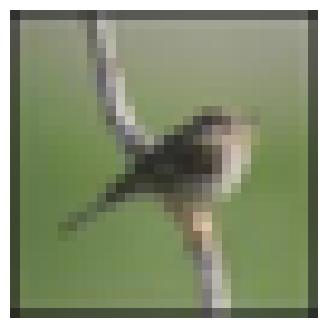

Teacher Model Prediction: bird
Student (Distilled) Prediction: bird
Student (Hard Labels) Prediction: bird

Teacher (VGG-16) Accuracy: 88.48%
Student (Distilled) Accuracy: 74.78%
Student (Hard Labels) Accuracy: 73.95%


In [ ]:
image_path = '/content/images/cifar10_bird_3333.png'
image = Image.open(image_path).convert('RGB')
image_np = np.array(image)

plt.figure(figsize=(4, 4))
plt.imshow(image_np)
plt.axis('off')
plt.show()

# Inference with Teacher
teacher_model.load_state_dict(torch.load('./models/teacher_vgg16.pt'))
teacher_prediction = infer_single_image(teacher_model, image_path, transform_test, 'Teacher')
print(f"Teacher Model Prediction: {teacher_prediction}")

# Inference with Student (Distilled)
student_model.load_state_dict(torch.load('./models/student_distilled.pt'))
student_prediction = infer_single_image(student_model, image_path, transform_test, 'Student (Distilled)')
print(f"Student (Distilled) Prediction: {student_prediction}")

# Inference with Student (Hard Labels)
student_model_hard.load_state_dict(torch.load('./models/student_hard.pt'))
student_hard_prediction = infer_single_image(student_model_hard, image_path, transform_test, 'Student (Hard Labels)')
print(f"Student (Hard Labels) Prediction: {student_hard_prediction}")

print(f"\nTeacher (VGG-16) Accuracy: {teacher_acc:.2f}%")
print(f"Student (Distilled) Accuracy: {student_acc:.2f}%")
print(f"Student (Hard Labels) Accuracy: {student_hard_acc:.2f}%")